# The Nature Conservancy Fisheries Monitoring

https://www.kaggle.com/c/the-nature-conservancy-fisheries-monitoring

In [11]:
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf

print(tf.__version__)

2.15.0


# Загружаем разметку

In [ ]:
TRAIN_PREFIX = 'data/fish/train'
for path in glob('data/fish/boxes/*.json'):

In [50]:
import os
import json
from glob import glob

TRAIN_PREFIX = 'data/fish/train'

def load_annotations():
    y_label = []
    boxes = dict()
    for path in glob('data/fish/boxes/*.json'):
        label = os.path.basename(path).split('_', 1)[0]
        with open(path) as src:
            for annotation in json.load(src):
                basename = os.path.basename(annotation['filename'])
                annotation['fish']=label.upper()
                annotation['filename'] = os.path.normpath(os.path.join(
                    TRAIN_PREFIX, label.upper(), basename))
                y_label.append(label.upper())
                for rect in annotation['annotations']:
                    rect['x'] += rect['width'] / 2
                    rect['y'] += rect['height'] / 2
                if os.path.isfile(annotation['filename']):
                    boxes.setdefault(label, []).append(annotation)
    return boxes, y_label


def draw_boxes(annotation, rectangles=None, image_size=None):

    def _draw(img, rectangles, scale_x, scale_y, color=(0, 255, 0)):
        for rect in rectangles:
            pt1 = (int((rect['x'] - rect['width'] / 2) * scale_x),
                   int((rect['y'] - rect['height'] / 2) * scale_y))
            pt2 = (int((rect['x'] + rect['width'] / 2) * scale_x),
                   int((rect['y'] + rect['height'] / 2) * scale_y))
            img = cv2.rectangle(img.copy(), pt1, pt2,
                                color=color, thickness=4)
        return img

    scale_x, scale_y = 1., 1.

    img = cv2.imread(annotation['filename'], cv2.IMREAD_COLOR)[..., ::-1]
    if image_size is not None:
        scale_x = 1. * image_size[0] / img.shape[1]
        scale_y = 1. * image_size[1] / img.shape[0]
        img = cv2.resize(img, image_size)

    img = _draw(img, annotation.get('annotations', []), scale_x, scale_y)

    if rectangles is not None:
        img = _draw(img, rectangles, 1., 1., (255, 0, 0))

    return img

In [51]:
boxes, y_label = load_annotations()  # загружаем разметку детекций

In [54]:
y_categorical = pd.get_dummies(y_label)

y_categorical=y_categorical.drop_duplicates()
y_categorical


ALB    BET    DOL    LAG  SHARK    YFT
0      True  False  False  False  False  False
1719  False   True  False  False  False  False
1919  False  False   True  False  False  False
2036  False  False  False   True  False  False
2103  False  False  False  False   True  False
2279  False  False  False  False  False   True

### Визуализируем разметку

In [55]:
pd.DataFrame(
    [(k, len(v)) for k, v in boxes.items()],
    columns=['class', 'count'])

class  count
0    alb   1719
1    bet    200
2    dol    117
3    lag     67
4  shark    176
5    yft    734

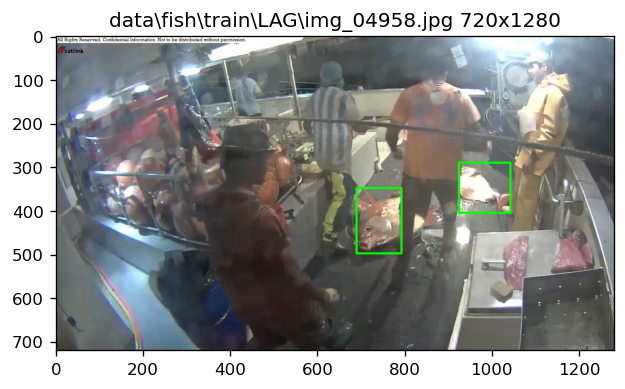

In [56]:
from matplotlib import pyplot as plt


annotation = boxes['lag'][25]
img = draw_boxes(annotation)

plt.figure(figsize=(6, 6), dpi=120)
plt.imshow(img)
plt.title('{} {}x{}'.format(
    annotation['filename'], img.shape[0], img.shape[1]));

### Распределение размеров разметки

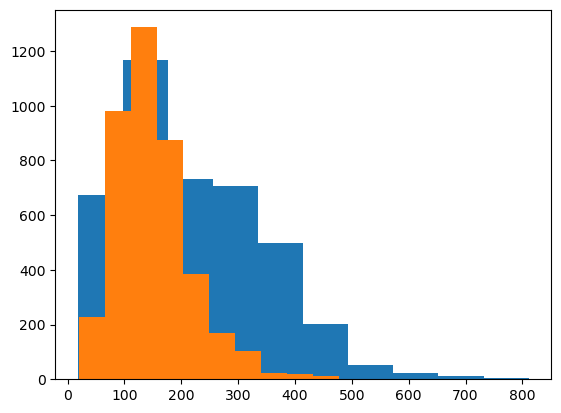

In [57]:
annotations = sum([box['annotations']
                   for box in sum(boxes.values(), [])], [])

widths = [rect['width'] for rect in annotations]
heights = [rect['height'] for rect in annotations]

plt.hist(widths)
plt.hist(heights);

# Экстрактор признаков

In [58]:
from tensorflow.keras.applications import vgg16

IMG_HEIGHT = 750
IMG_WIDTH = 1200

features = vgg16.VGG16(weights='imagenet',
                       include_top=False,
                       input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# дообучаем последние 5 слоев
for layer in features.layers[:-5]:
    layer.trainable = False
    
feature_tensor = features.layers[-1].output
print(feature_tensor.shape)

(None, 23, 37, 512)


# Сетка якорей (anchor grid)

In [59]:
FEATURE_SHAPE = (feature_tensor.shape[1],
                 feature_tensor.shape[2])

GRID_STEP_H = IMG_HEIGHT / FEATURE_SHAPE[0]
GRID_STEP_W = IMG_WIDTH / FEATURE_SHAPE[1]

ANCHOR_WIDTH = 150.
ANCHOR_HEIGHT = 150. 

# сетка якорей, размер определяется соотношением 
# размера входного изображения и размером тензора признаков
ANCHOR_CENTERS = np.mgrid[GRID_STEP_H/2:IMG_HEIGHT:GRID_STEP_H,
                          GRID_STEP_W/2:IMG_WIDTH:GRID_STEP_W]

In [60]:
from scipy.special import softmax

def iou(rect, x_scale, y_scale, anchor_x, anchor_y,
        anchor_w=ANCHOR_WIDTH, anchor_h=ANCHOR_HEIGHT):

    rect_x1 = (rect['x'] - rect['width'] / 2) * x_scale
    rect_x2 = (rect['x'] + rect['width'] / 2) * x_scale

    rect_y1 = (rect['y'] - rect['height'] / 2) * y_scale
    rect_y2 = (rect['y'] + rect['height'] / 2) * y_scale

    anch_x1, anch_x2 = anchor_x - anchor_w / 2, anchor_x + anchor_w / 2
    anch_y1, anch_y2 = anchor_y - anchor_h / 2, anchor_y + anchor_h / 2

    dx = (min(rect_x2, anch_x2) - max(rect_x1, anch_x1))
    dy = (min(rect_y2, anch_y2) - max(rect_y1, anch_y1))

    intersection = dx * dy if (dx > 0 and dy > 0) else 0.

    anch_square = (anch_x2 - anch_x1) * (anch_y2 - anch_y1)
    rect_square = (rect_x2 - rect_x1) * (rect_y2 - rect_y1)
    union = anch_square + rect_square - intersection

    return intersection / union


def encode_anchors(annotation, img_shape, iou_thr=0.5):
    encoded = np.zeros(shape=(FEATURE_SHAPE[0],
                              FEATURE_SHAPE[1], 11), dtype=np.float32)
    x_scale = 1. * IMG_WIDTH / img_shape[1]
    y_scale = 1. * IMG_HEIGHT / img_shape[0]
    
    y_cat = np.array(y_categorical[annotation['fish']])
    
    for rect in annotation['annotations']:
        scores = []
        for row in range(FEATURE_SHAPE[0]):
            for col in range(FEATURE_SHAPE[1]):
                anchor_x = ANCHOR_CENTERS[1, row, col]
                anchor_y = ANCHOR_CENTERS[0, row, col]
                score = iou(rect, x_scale, y_scale, anchor_x, anchor_y)
                scores.append((score, anchor_x, anchor_y, row, col))

        scores = sorted(scores, reverse=True)
        if scores[0][0] < iou_thr:
            scores = [scores[0]]  # default anchor
        else:
            scores = [e for e in scores if e[0] > iou_thr]

        for score, anchor_x, anchor_y, row, col in scores:
            dx = (anchor_x - rect['x'] * x_scale) / ANCHOR_WIDTH
            dy = (anchor_y - rect['y'] * y_scale) / ANCHOR_HEIGHT
            dw = (ANCHOR_WIDTH - rect['width'] * x_scale) / ANCHOR_WIDTH
            dh = (ANCHOR_HEIGHT - rect['height'] * y_scale) / ANCHOR_HEIGHT
            # TODO: добавьте one-hot encoding в разметку для классов
            encoded[row, col] = [1., dx, dy, dw, dh,
                                 y_cat[0], y_cat[1], y_cat[2], y_cat[3], y_cat[4], y_cat[5]]

    return encoded


def _sigmoid(x):
    return 1. / (1. + np.exp(-x))


def decode_prediction(prediction, conf_thr=0.1):
    rectangles = []
    
    for row in range(FEATURE_SHAPE[0]):
        for col in range(FEATURE_SHAPE[1]):
            y_cat = np.empty(6)
            
            logit, dx, dy, dw, dh,y_cat[0],y_cat[1], y_cat[2], y_cat[3], y_cat[4], y_cat[5] = prediction[row, col]
            
            conf = _sigmoid(logit)
            y_cat = softmax(y_cat)
            
            if conf > conf_thr:
                anchor_x = ANCHOR_CENTERS[1, row, col]
                anchor_y = ANCHOR_CENTERS[0, row, col]
                rectangles.append({'x': anchor_x - dx * ANCHOR_WIDTH,
                                   'y': anchor_y - dy * ANCHOR_HEIGHT,
                                   'width': ANCHOR_WIDTH - dw * ANCHOR_WIDTH,
                                   'height': ANCHOR_HEIGHT - dh * ANCHOR_HEIGHT,
                                   'conf': conf,
                                   'label': np.argmax(_sigmoid(y_cat)),
                                   'labels': y_cat})
            
    return rectangles


def non_max_suppression(rectangles, max_output_size, iou_threshold=0.5):
    if not rectangles:
        #print()
        return rectangles
    

    boxes = [[r['y'],
              r['x'],
              r['y'] + r['height'],
              r['x'] + r['width']] for r in rectangles]
    scores = [r['conf'] for r in rectangles]
    indices = tf.image.non_max_suppression(np.array(boxes),
                                           np.array(scores),
                                           max_output_size,
                                           iou_threshold)

    return [rectangles[i] for i in indices]

In [61]:
boxes['lag'][0]

{'annotations': [{'class': 'rect',
   'height': 308.0000000000008,
   'width': 398.0000000000009,
   'x': 790.0000000000019,
   'y': 325.0000000000008},
  {'class': 'rect',
   'height': 224.0000000000005,
   'width': 366.0000000000008,
   'x': 861.000000000002,
   'y': 607.0000000000015}],
 'class': 'image',
 'filename': 'data\\fish\\train\\LAG\\img_07919.jpg',
 'fish': 'LAG'}

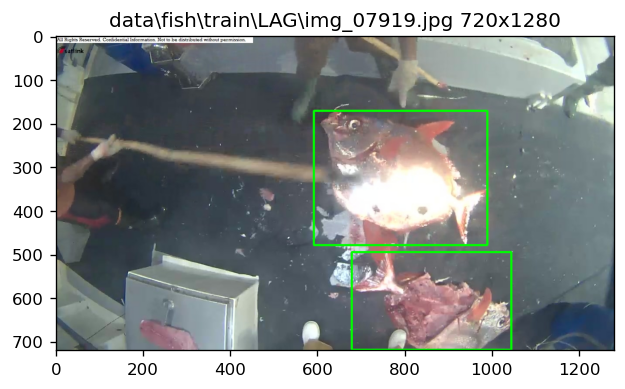

In [62]:
from matplotlib import pyplot as plt


annotation = boxes['lag'][0]
img = draw_boxes(annotation)

plt.figure(figsize=(6, 6), dpi=120)
plt.imshow(img)
plt.title('{} {}x{}'.format(
    annotation['filename'], img.shape[0], img.shape[1]));

### Валидация энкодинга/декодинга якорей

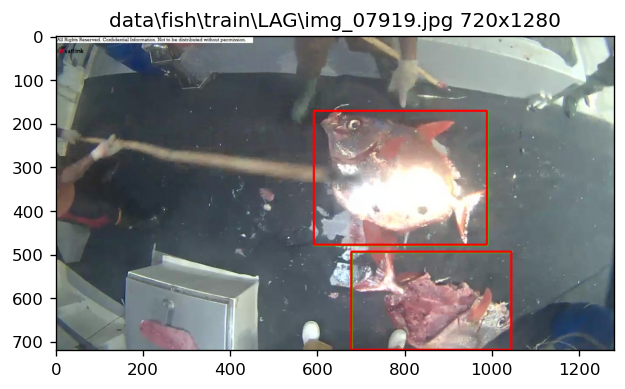

In [63]:
from matplotlib import pyplot as plt
annotation = boxes['lag'][0]

encoded = encode_anchors(annotation,
                         img_shape=(IMG_HEIGHT, IMG_WIDTH),
                         iou_thr=0.5)

decoded = decode_prediction(encoded, conf_thr=0.7)
decoded = sorted(decoded, key = lambda e: -e['conf'])

plt.figure(figsize=(6, 6), dpi=120)
plt.imshow(draw_boxes(annotation, decoded))
plt.title('{} {}x{}'.format(
    annotation['filename'], img.shape[0], img.shape[1]));

## Функция потерь

In [64]:
K = tf.keras.backend


def confidence_loss(y_true, y_pred):
    conf_loss = K.binary_crossentropy(y_true[..., 0],
                                      y_pred[..., 0],
                                      from_logits=True)
    return conf_loss

def ctg_loss_f(y_true, y_pred):
    ctg_loss_loc = K.categorical_crossentropy(y_true[..., 5:],
                                              y_pred[..., 5:],
                                              from_logits=True)
    return ctg_loss_loc


def smooth_l1(y_true, y_pred):
    abs_loss = K.abs(y_true[..., 1:5] - y_pred[..., 1:5])
    square_loss = 0.5 * K.square(y_true[..., 1:5] - y_pred[..., 1:5])
    mask = K.cast(K.greater(abs_loss, 1.), 'float32')
    total_loss = (abs_loss - 0.5) * mask + 0.5 * square_loss * (1. - mask)
    return K.sum(total_loss, axis=-1)


def total_loss(y_true, y_pred, neg_pos_ratio=3):
    batch_size = K.shape(y_true)[0]

    y_true = K.reshape(y_true, (batch_size, -1, 11))
    y_pred = K.reshape(y_pred, (batch_size, -1, 11))

# TODO: добавьте функцию потерь для классификации детекции

    # ctg loss
    ctg_loss = ctg_loss_f(y_true, y_pred)

    # confidence loss
    conf_loss = confidence_loss(y_true, y_pred)

    # smooth l1 loss
    loc_loss = smooth_l1(y_true, y_pred)

    # positive examples loss
    
    pos_conf_loss = K.sum(conf_loss * y_true[..., 0], axis=-1)
    pos_ctg_loss = K.sum(ctg_loss * y_true[..., 0], axis=-1)
    pos_loc_loss = K.sum(loc_loss * y_true[..., 0], axis=-1)

    # negative examples loss
    anchors = K.shape(y_true)[1]
    num_pos = K.sum(y_true[..., 0], axis=-1)
    num_pos_avg = K.mean(num_pos)
    num_neg = K.min([neg_pos_ratio * (num_pos_avg) + 1., K.cast(anchors, 'float32')])

    
    # hard negative mining
    neg_conf_loss, _ = tf.nn.top_k(conf_loss * (1. - y_true[..., 0]),k=K.cast(num_neg, 'int32'))
    neg_conf_loss = K.sum(neg_conf_loss, axis=-1)
    

    

    # total loss
    
    total_conf_loss = (neg_conf_loss + pos_conf_loss) / (num_neg + num_pos + 1e-32)
    
    loc_loss = pos_loc_loss / (num_pos + 1e-32)
    ctg_loss = pos_ctg_loss / (num_pos + 1e-32)

    return total_conf_loss + 0.5 * loc_loss + 10*ctg_loss

## Загрузка данных

In [65]:
from random import shuffle

def load_img(path, target_size=(IMG_WIDTH, IMG_HEIGHT)):
    img = cv2.imread(path, cv2.IMREAD_COLOR)[...,::-1]
    img_shape = img.shape
    img_resized = cv2.resize(img, target_size)
    return img_shape, vgg16.preprocess_input(img_resized.astype(np.float32))

def data_generator(boxes, batch_size=32):
    boxes = sum(boxes.values(), [])
    while True:
        shuffle(boxes)
        for i in range(len(boxes)//batch_size):
            X, y = [], []
            for j in range(i*batch_size,(i+1)*batch_size):
                img_shape, img = load_img(boxes[j]['filename'])
                
                y.append(encode_anchors(boxes[j], img_shape))
                X.append(img)
            yield np.array(X), np.array(y)

## Добавляем выход детектора

In [66]:
eature_tensor = features.layers[-1].output
output = tf.keras.layers.BatchNormalization()(feature_tensor)

# TODO: добавьте выходы для классификации детекции
output = tf.keras.layers.Conv2D(11,
                                kernel_size=(1, 1), 
                                activation='linear',
                                kernel_regularizer='l2')(output)

model = tf.keras.models.Model(inputs=features.inputs, outputs=output)
model.summary()
print(feature_tensor.shape)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 750, 1200, 3)]    0         
                                                                 
 block1_conv1 (Conv2D)       (None, 750, 1200, 64)     1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 750, 1200, 64)     36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 375, 600, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 375, 600, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 375, 600, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 187, 300, 128)     0   

## Обучение

In [67]:
adam = tf.keras.optimizers.legacy.Adam(lr=3e-4, decay=1e-6)
model.compile(optimizer=adam, loss=total_loss,
              metrics=[ctg_loss_f,confidence_loss,smooth_l1])

d:\Anaconda3\Lib\site-packages\keras\src\optimizers\legacy\adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [69]:
batch_size = 5

gen = data_generator(boxes, batch_size=batch_size)
steps_per_epoch = sum(map(len, boxes.values()), 0) / batch_size

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'fishdetector.keras',
    monitor='loss',
    verbose=1,  
    save_best_only=True, 
    save_weights_only=False,
    mode='auto',
    save_freq=10)

model.fit(gen, 
          steps_per_epoch=steps_per_epoch,
          epochs=20,
          callbacks=[checkpoint])

Epoch 1/20
  9/602 [..............................] - ETA: 1:13:22 - loss: 22.2007 - ctg_loss_f: 0.0065 - confidence_loss: 0.7607 - smooth_l1: 2.0394
Epoch 1: loss improved from inf to 20.99583, saving model to fishdetector.keras
 19/602 [..............................] - ETA: 1:12:41 - loss: 19.3310 - ctg_loss_f: 0.0060 - confidence_loss: 0.6325 - smooth_l1: 1.7452
Epoch 1: loss improved from 20.99583 to 18.85987, saving model to fishdetector.keras
 29/602 [>.............................] - ETA: 1:11:32 - loss: 17.1380 - ctg_loss_f: 0.0053 - confidence_loss: 0.5263 - smooth_l1: 1.4829
Epoch 1: loss improved from 18.85987 to 16.97530, saving model to fishdetector.keras
 39/602 [>.............................] - ETA: 1:10:16 - loss: 15.5074 - ctg_loss_f: 0.0048 - confidence_loss: 0.4462 - smooth_l1: 1.2931
Epoch 1: loss improved from 16.97530 to 15.33478, saving model to fishdetector.keras
 49/602 [=>............................] - ETA: 1:09:14 - loss: 14.8021 - ctg_loss_f: 0.0045 - con

## Результат работы детектора

In [71]:
model.load_weights("D:/GITHUB/CV/fishdetector.keras")

1/1 [==============================] - 1s 943ms/step


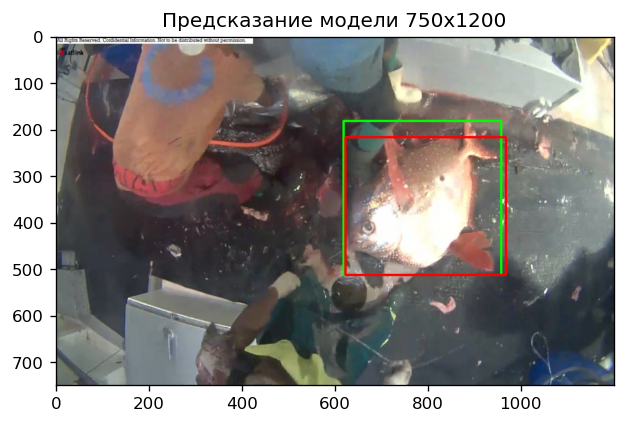

In [74]:
annotation = boxes['lag'][40]

_, sample_img = load_img(annotation['filename'])
pred = model.predict(np.array([sample_img,]))

decoded = decode_prediction(pred[0], conf_thr=0.2)
decoded = non_max_suppression(decoded,
                              max_output_size=5,
                              iou_threshold=0.1)

plt.figure(figsize=(6, 6), dpi=120)
img = draw_boxes(annotation, decoded, (IMG_WIDTH, IMG_HEIGHT))
plt.imshow(img)
plt.title('Предсказание модели {}x{}'.format(*img.shape));

## Визуализируем предсказание на тесте

1/1 [==============================] - 1s 935ms/step


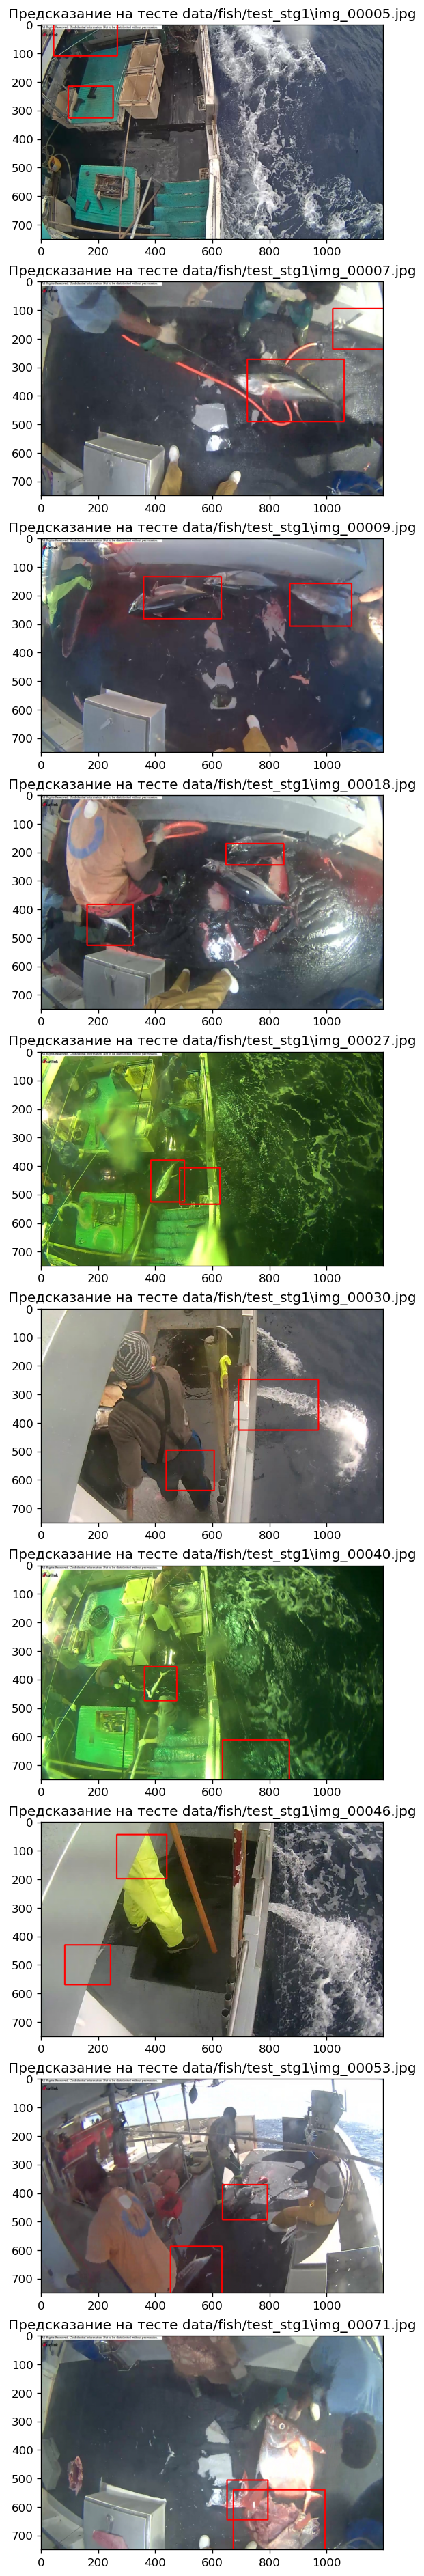

In [75]:
test_images = glob('data/fish/test_stg1/*.jpg')[:10]


plt.figure(figsize=(6, 4 * len(test_images)), dpi=120)

for i, filename in enumerate(test_images):
    _, sample_img = load_img(filename)
    pred = model.predict(np.array([sample_img,]))

    decoded = decode_prediction(pred[0], conf_thr=0.0)
    decoded = non_max_suppression(decoded,
                                  max_output_size=2,
                                  iou_threshold=0.1)
    
    plt.subplot(len(test_images), 1, i + 1)
    img = draw_boxes({'filename': filename}, decoded, (IMG_WIDTH, IMG_HEIGHT))
    plt.imshow(img)
    plt.title('Предсказание на тесте {}'.format(filename));

## Агрегация результатов

In [ ]:
# TODO: предскажите класс рыбы для фотографии из тестовой выборки
#
# Подготовьте файл с предсказаниями вероятностей для каждой фотографии:
# image,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT
# img_00001.jpg,1,0,0,0,0,...,0
# img_00002.jpg,0.3,0.1,0.6,0,...,0

In [76]:
y_categorical = pd.get_dummies(y_label)

y_categorical=y_categorical.drop_duplicates()
y_categorical

ALB    BET    DOL    LAG  SHARK    YFT
0      True  False  False  False  False  False
1719  False   True  False  False  False  False
1919  False  False   True  False  False  False
2036  False  False  False   True  False  False
2103  False  False  False  False   True  False
2279  False  False  False  False  False   True

In [77]:
result_table = pd.DataFrame(columns=['image', 'ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK','YFT'])
correct=(1.0-(0.123081+0.079142))
for i, file in enumerate(glob('data/fish/test_stg1/*.jpg')):
        bn = os.path.basename(file)
        # print(bn)
        _, sample_img = load_img(file)
        
        pred = model.predict(np.array([sample_img,]))[0]

        decoded = decode_prediction(pred, conf_thr=0.01)
        decoded = non_max_suppression(decoded,
                              max_output_size=1,
                              iou_threshold=0.5)
        
        if not decoded:
            decoded=[correct/6 for i in range(6)]
        else:
            decoded = decoded[0]['labels']*correct

        result_table.loc[i, 'image'] = bn
        result_table.loc[i, 'ALB'] = decoded[5]
        result_table.loc[i, 'BET'] = decoded[1]
        result_table.loc[i, 'DOL'] = decoded[4]
        result_table.loc[i, 'LAG'] = decoded[3]
        result_table.loc[i, 'SHARK'] = decoded[0]
        result_table.loc[i, 'YFT'] = decoded[2]
        result_table.loc[i, 'NoF'] = 0.123081 # фиксированная вероятность для класса 'No Fishes' из файла sample_submission
        result_table.loc[i, 'OTHER'] = 0.079142 # фиксированная вероятность для класса 'Other Fishes' из файла sample_submission

i += 1    

for j, file in enumerate(glob('data/fish/test_stg2/*.jpg')):
    bn = os.path.basename(file)

    bn = "test_stg2/" + bn

    _, sample_img = load_img(file)

    pred = model.predict(np.array([sample_img,]))[0]

    decoded = decode_prediction(pred, conf_thr=0.01)
    decoded = non_max_suppression(decoded,
                          max_output_size=1,
                          iou_threshold=0.5)
    if not decoded:
            decoded=[correct/6 for i in range(6)]
    else:
        decoded = decoded[0]['labels']*correct
            
    #decoded = decoded[0]['labels']

    result_table.loc[i + j, 'image'] = bn
    result_table.loc[i + j, 'ALB'] = decoded[5]
    result_table.loc[i + j, 'BET'] = decoded[1]
    result_table.loc[i + j, 'DOL'] = decoded[4]
    result_table.loc[i + j, 'LAG'] = decoded[3]
    result_table.loc[i + j, 'SHARK'] = decoded[0]
    result_table.loc[i + j, 'YFT'] = decoded[2]
    result_table.loc[i + j, 'NoF'] = 0.123081 # фиксированная вероятность для класса 'No Fishes' из файла sample_submission
    result_table.loc[i + j, 'OTHER'] = 0.079142 # фиксированная вероятность для класса 'Other Fishes' из файла sample_submission

1/1 [==============================] - 1s 1s/step


In [78]:
result_table

image       ALB       BET       DOL       LAG  \
0                  img_00005.jpg  0.132963  0.132963  0.132963  0.132963   
1                  img_00007.jpg   0.79773  0.000002  0.000001  0.000001   
2                  img_00009.jpg   0.00009  0.107816  0.000003  0.000005   
3                  img_00018.jpg       0.0  0.000002       0.0       0.0   
4                  img_00027.jpg  0.281742  0.000815  0.003357   0.00027   
...                          ...       ...       ...       ...       ...   
13148  test_stg2/image_12149.jpg  0.000026  0.001184  0.000003  0.000022   
13149  test_stg2/image_12150.jpg  0.000001       0.0  0.000001  0.000001   
13150  test_stg2/image_12151.jpg  0.132963  0.132963  0.132963  0.132963   
13151  test_stg2/image_12152.jpg  0.000006  0.000048  0.000008  0.000605   
13152  test_stg2/image_12153.jpg  0.028523  0.006729  0.000217  0.001941   

            NoF     OTHER     SHARK       YFT  
0      0.123081  0.079142  0.132963  0.132963  
1      0.123081  0.079142  0.000044       0.0  
2      0.123081  0.079142  0.689861  0.000001  
3      0.123081  0.079142  0.797774       0.0  
4      0.123081  0.079142  0.510407  0.001184  
...         ...       ...       ...       ...  
13148  0.123081  0.079142  0.796525  0.000016  
13149  0.123081  0.079142  0.797773  0.000001  
13150  0.123081  0.079142  0.132963  0.132963  
13151  0.123081  0.079142  0.797041   0.00007  
13152  0.123081  0.079142  0.221597   0.53877  

[13153 rows x 9 columns]

In [79]:
result_table.to_csv("submission.csv", index=False)
print(os.listdir("./"))

['.git', '.gitattributes', '.gitignore', 'cats-dogs-vgg16.keras', 'Data', 'fishdetector.keras', 'HW-dogs-vs-cats.ipynb', 'HW_digit_rec.ipynb', 'HW_fish.ipynb', 'Kaggle_score.png', 'README.md', 'submission.csv', 'submit.csv']


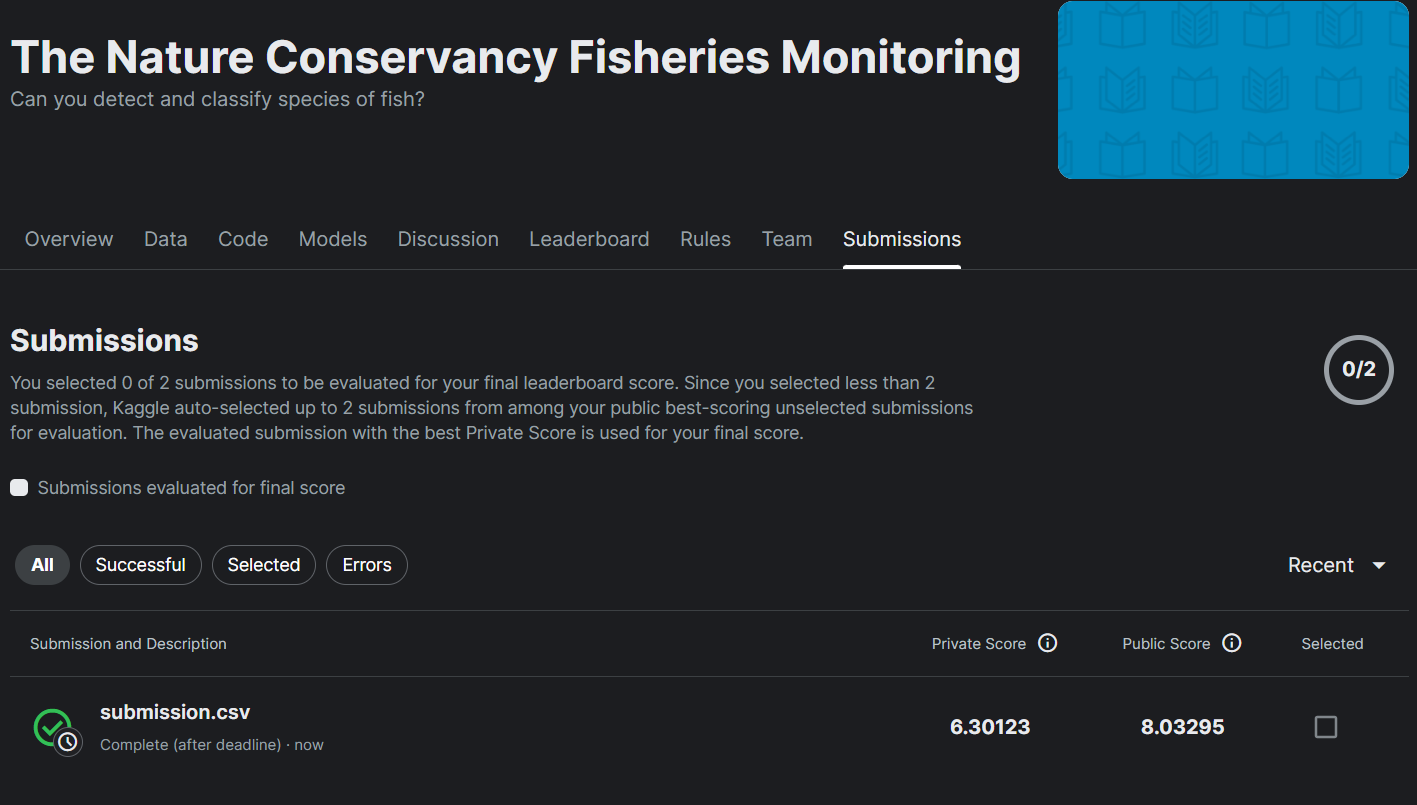